### Necessary Imports

In [300]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import random
import math
from IPython.display import clear_output
%matplotlib inline

### Loading Datasets

***Train Dataset***

In [301]:
train_df = pd.read_csv("train.csv", names=["x1", "x2", "x3", "x4", "label"])
train_df.head()

,x1,x2,x3,x4,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [302]:
train_df.shape

(135, 5)

***Test Dataset***

In [303]:
test_df = pd.read_csv("test.csv", names=["x1", "x2", "x3", "x4", "label"])
test_df.head()

,x1,x2,x3,x4,label
0,4.8,3.0,1.4,0.3,Iris-setosa
1,5.1,3.8,1.6,0.2,Iris-setosa
2,4.6,3.2,1.4,0.2,Iris-setosa
3,5.3,3.7,1.5,0.2,Iris-setosa
4,5.0,3.3,1.4,0.2,Iris-setosa


In [304]:
test_df.shape

(15, 5)

### Analysing Training Dataset

In [305]:
num_of_features = 4
classes = sorted(train_df['label'].unique())
print("Classes:", classes, "\nNumber of features:", num_of_features)

Classes: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'] 
Number of features: 4


***Dataset is equally distributed***

Text(0.5, 0, 'Labels')

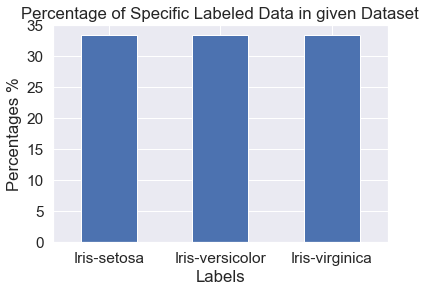

In [306]:
ax = (train_df['label'].value_counts(normalize=True)*100).plot(
        kind="bar", title='Percentage of Specific Labeled Data in given Dataset')
ax.tick_params(axis='x', labelrotation=0)
ax.set_ylabel('Percentages %')
ax.set_xlabel('Labels')

### Preprocessing

* ***Label Encoding***

In [307]:
def LabelEncoder(df):
    '''
        Encodes 'label' column of the Dataframe
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
    '''
    df['label'] = df['label'].astype('category')
    df['encoded_labels'] = df['label'].cat.codes

In [308]:
# Train Dataset
LabelEncoder(train_df)
train_df = train_df.drop(columns=["label"])
train_df = train_df.rename(columns={"encoded_labels": "label"})

# Test Dataset
LabelEncoder(test_df)
test_df = test_df.drop(columns=["label"])
test_df = test_df.rename(columns={"encoded_labels": "label"})

In [309]:
train_df.head()

,x1,x2,x3,x4,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [310]:
test_df.head()

,x1,x2,x3,x4,label
0,4.8,3.0,1.4,0.3,0
1,5.1,3.8,1.6,0.2,0
2,4.6,3.2,1.4,0.2,0
3,5.3,3.7,1.5,0.2,0
4,5.0,3.3,1.4,0.2,0


* ***Feature Normalization***

As KNN does not make assumptions about the distribution of the data and we also do not have any knowledge about the data distribution. That's why we need to normalize our features to avoid the effect of any one feature (i.e. dimension) on the classification decision.

In [311]:
def mean_normalize(df, columns):
    '''
        Mean normalizes given columns of the Dataframe
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
            
        columns: list
            Array of shape (m, ), where m is the number of columns you want to normalize
    '''
    for col in columns:
        df[col] = (df[col]-df[col].mean()) / (df[col].std())

In [312]:
mean_normalize(train_df, ["x1", "x2", "x3", "x4"])
mean_normalize(test_df, ["x1", "x2", "x3", "x4"])

* ***Vectorization & Separation of Features and Labels***

In [313]:
def preprocessor(df, n):
    '''
        Converts Dataframe to a list of JSON objects, separating 'features' and 'label'
        
        Arguments
        ---------
        df : Pandas Dataframe
            Dataframe of shape (m, n), where m is number of rows and n is the number of columns
            
        n: int
            Number of features
        
        Returns
        -------
        data: list of JSON Objects
            Array of shape (m, ), where m is number of instances and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
    '''
    data = list()
    for _, row in df.iterrows():
        temp = np.array(row)
        data.append({'features': temp[0:n], 'label': int(temp[n])})
    return data

In [314]:
# Train Dataset
train = preprocessor(train_df, num_of_features)

In [315]:
# Test Dataset
test = preprocessor(test_df, num_of_features)

### Predicting Label

* **Function to find K Nearest Neighbours using** ***QuickSelect*** **and** ***Order Statistics*** **in O(n)**

In [316]:
def sort_by_pivot(arr, start, end):
    '''
        * Uses the concept of QUICKSELECT and ORDER STATISTICS, and chooses a random element 'pivot' 
        and puts it at a postion 'i', where arr[i] >= arr[j] for all (j < i) and arr[i] <= arr[k] for 
        all (k > i).
        * Or Returns the index of 'pivot-th' smallest element of the 'arr'.
        * Time Complexity = O(n)
        
        Arguments
        ---------
        arr: list
            Array of shape (m, ), where m is the number of elements in the list
        
        start, end: int, int
            Start and end index of arr between which you want to find pivot and sort it accordingly
        
        Returns
        -------
        pivot: int
            Current position of the correctly sorted pivot in the arr. Element at 'pivot' 
            will be the 'pivot-th' smallest element in arr.
    '''
    pivot = random.randint(start,end)
    pivot_val = arr[pivot]['distance']
    i = -1
    j = end
    temp = arr[pivot]
    arr[pivot] = arr[j]
    arr[j] = temp
    i_start = True
    while True:
        if i_start:
            i = i + 1
            if arr[i]['distance'] >= pivot_val:
                i_start = False
        if i == j:
            t = arr[i]
            arr[i] = arr[end]
            arr[end] = t
            break
        if not i_start:
            j = j - 1
        if arr[j]['distance'] < pivot_val and not i_start:
            t = arr[i]
            arr[i] = arr[j]
            arr[j] = t
            i_start = True
    pivot = i
    return pivot

def get_KNN(arr, k):
    '''
        * Uses the concept of QUICKSELECT and ORDER STATISTICS, and returns the 'k' smallest elements from the 'arr'.
        * Time Complexity = O(n)
        
        Arguments
        ---------
        arr: list
            Array of shape (m, ), where m is the number of elements in the list
        
        k: int
            The number of smallest elements that are to be returned.
        
        Returns
        -------
        pivot: int
            Current position of the correctly sorted pivot in the arr. Element at 'pivot' 
            will be the 'pivot-th' smallest element in arr.
    '''
    if k > len(arr):
        return "Invalid Input"
    start = 0
    end = len(arr) - 1
    while True:
        if start == end or (np.abs(start-end) == 1 and arr[start] == arr[end]):
            return arr[0:k]
        index = sort_by_pivot(arr, start, end)
        if index == (k - 1):
            return arr[0:k]
        elif index < (k - 1):
            start = index + 1
        else:
            end = index - 1
            
def get_max_label(arr, num_classes):
    '''
        Returns the label that occurs the most in the 'arr'.
        
        Arguments
        ---------
        arr: list
            Array of shape (m, ), where m is the number of elements in the list
        
        num_classes: int
            Number of classes in the dataset
        
        Returns
        -------
        label: int
            The encoded label of the most occured label in the 'arr'
    '''
    label = None
    label_count = np.zeros(num_classes)
    for x in arr:
        label_count[x['label']] += 1
    label = np.argmax(label_count)
    return label

In [317]:
def predict_label(train, d, k, num_classes):
    '''
        Applys KNN Algorithm and predicts the label of 'd' instance
        
        Arguments
        ---------
        train: list of JSON Objects
            Array of shape (m, ), where m is number of training examples and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
            
        d: JSON Object
            A JSON object with 2 keys, 'features' that is a NUMPY array of shape (n, ) where n is the number of 
            features and 'label' is an integer representing encoded label of that instance
        
        k: int
            The number of smallest elements that are to be returned.
            
        num_classes: int
            Number of classes in the dataset
        
        Returns
        -------
        y_cap: int
            The predicted and encoded label of 'd'
    '''
    y_cap = None
    distances = np.array([{'distance': np.linalg.norm(x['features']-d['features']), 'label': x['label']} for x in train])# O(mn)
    KNN = get_KNN(distances, k) # O(n)
    y_cap = get_max_label(KNN, num_classes) # O(k)
    return y_cap

In [318]:
def testKNN(train, test, k, num_classes):
    '''
        Applys KNN Algorithm and predicts the labels of all test dataset and builds a confusion matrix
        
        Arguments
        ---------
        train: list of JSON Objects
            Array of shape (m, ), where m is number of training examples and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
            
        test: list of JSON Objects
            Array of shape (m, ), where m is number of testing instances and every element is a JSON object with 
            2 keys 'features' that is a NUMPY array of shape (n, ) where n is the number of features and 
            'label' is an integer representing encoded label of that instance
        
        k: int
            The number of smallest elements that are to be returned.
            
        num_classes: int
            Number of classes in the dataset
        
        Returns
        -------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
    '''
    cm = np.zeros((num_classes, num_classes))
    
    for d in test:
        pred_c = predict_label(train, d, k, num_classes)
        cm[pred_c][d['label']] += 1
    
    return cm

In [319]:
def evaluation_matrix(cm, classes):
    '''
        Plots confusion matrix and calculates Macro accuracy, precision, recall, f1 score

        Arguments
        ---------
        cm: numpy array
            Array of shape (k, k), where k is the number of classes
            
        classes: list
            Array of encoded labels of shape (c, ), where c is the number of classes
    '''
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
              columns = [i for i in classes])
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="BuPu")
    plt.show()
    # Calculating Accuracy
    accuracy = np.sum(np.array([cm[i][i] for i in range(len(cm))])) / np.sum(cm)
    print("\n\nAccuracy = %.2f" % (accuracy))

### Evaluation Report

* ***For K = 1***

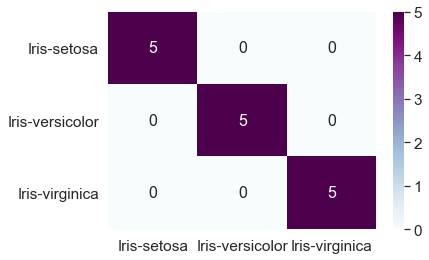



Accuracy = 1.00


In [320]:
cm = testKNN(train, test, 1, len(classes))
evaluation_matrix(cm, classes)

* ***For K = 3***

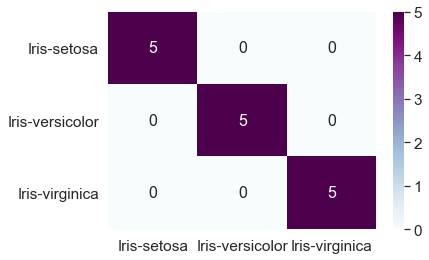



Accuracy = 1.00


In [321]:
cm = testKNN(train, test, 3, len(classes))
evaluation_matrix(cm, classes)

* ***For K = 5***

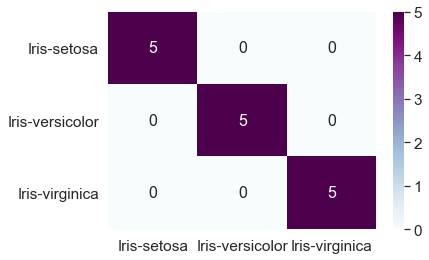



Accuracy = 1.00


In [322]:
cm = testKNN(train, test, 5, len(classes))
evaluation_matrix(cm, classes)